In [33]:
import pandas as pd

import numpy as np

from nltk.corpus import stopwords

from pymorphy3 import MorphAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score,f1_score,roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
df_train=pd.read_csv("clean_train.csv")
df_test=pd.read_csv("clean_test.csv")

In [4]:
df_train.dtypes

id                                 int64
comment                           object
rating                             int64
Вопрос не решен                    int64
Вопрос решен                       int64
Не понравилось качество услуги     int64
Не понравился результат услуги     int64
Понравилась работа сотрудников     int64
Понравилась скорость работы        int64
Понравилось качество услуги        int64
Понравился результат услуги        int64
Претензии и предложения            int64
dtype: object

In [5]:
tag_columns=["Вопрос не решен",
             "Вопрос решен",
             "Не понравилось качество услуги",
             "Не понравился результат услуги",
             "Понравилась работа сотрудников",
             "Понравилась скорость работы",
             "Понравилось качество услуги",
             "Понравился результат услуги",
             "Претензии и предложения"]

## препроцессинг

### леметезация

In [6]:
morph=MorphAnalyzer()
def lemmatize_text(text):
    words=text.split()
    return " ".join([morph.parse(word)[0].normal_form for word in words])

df_train["comment"]=df_train["comment"].apply(lemmatize_text)
df_test["comment"]=df_test["comment"].apply(lemmatize_text)

### веса для тэгов

In [7]:
def calculate_class_weights(y):
    class_weights=[]
    for tag in y.columns:
        pos=np.sum(y[tag])
        neg=len(y)-pos
        class_weights.append({0:1,1:neg/pos if pos>0 else 1})
    return class_weights

y=df_train[tag_columns]
class_weights=calculate_class_weights(y)

In [8]:
class_weights

[{0: 1, 1: 22.069444444444443},
 {0: 1, 1: 0.8272827282728272},
 {0: 1, 1: 26.683333333333334},
 {0: 1, 1: 32.89795918367347},
 {0: 1, 1: 4.688356164383562},
 {0: 1, 1: 1.6704180064308682},
 {0: 1, 1: 4.7874564459930316},
 {0: 1, 1: 3.6396648044692737},
 {0: 1, 1: 11.679389312977099}]

### стоп слова

In [9]:
russian_stop_words=stopwords.words("russian")
preprocessor=ColumnTransformer(
    transformers=[
        ("text",TfidfVectorizer(
            # stop_words=russian_stop_words, #тут стоп слова нужны, ибо меняют смысл
            max_features=5000,
            ngram_range=(1,2)),
        "comment"),
        ("num",StandardScaler(),["rating"])],
    remainder="drop")

## Модели

In [10]:
X_train=df_train[["comment","rating"]]
y_train=df_train[tag_columns]

X_test=df_test[["comment","rating"]]
y_test=df_test[tag_columns]

### логистическая регрессия

In [11]:
model=Pipeline([
    ("preprocessor",preprocessor),
    ("clf",MultiOutputClassifier(
        LogisticRegression(
            max_iter=1000,
            class_weight="balanced")))])
param_grid = {
    "preprocessor__text__max_features":[3000,5000,7000],
    "preprocessor__text__ngram_range":[(1,1),(1,2)],
    "clf__estimator__C":[0.1,1,10],}
grid_search = GridSearchCV(
                           model,
                           param_grid,
                           scoring="roc_auc_ovr",
                           cv=3,
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train,y_train)
model_logreg=grid_search.best_estimator_
print("Best parameters:",grid_search.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'clf__estimator__C': 10, 'preprocessor__text__max_features': 5000, 'preprocessor__text__ngram_range': (1, 2)}


### случайный лес

In [12]:
model_rngfor=Pipeline([
    ("preprocessor",preprocessor),
    ("clf",MultiOutputClassifier(
        RandomForestClassifier(
            class_weight="balanced",
            n_estimators=100)))])

### линейная SVC

In [13]:
model_linsvc = Pipeline([
    ("preprocessor",preprocessor),
    ("clf",MultiOutputClassifier(
        CalibratedClassifierCV(
            LinearSVC(class_weight="balanced",
                      max_iter=1000,
                      dual=False),
            cv=5)))])

### кэт буст

In [14]:
model_catbst=Pipeline([
    ("preprocessor",preprocessor),
    ("clf",MultiOutputClassifier(
        CatBoostClassifier(
            n_estimators=100,
            verbose=0)))])

## тренировка и оценка

### тренировка

In [15]:
# model=model_rngfor
# model.fit(X_train, y_train)
# y_proba_train=model.predict_proba(X_train)
# y_pred_train=model.predict(X_train)
# y_proba_test=model.predict_proba(X_test)
# y_pred_test=model.predict(X_test)

### оценка

In [16]:
# roc_auc_scores={}
# f1_scores={}
# print("|-"+"-"*30+"-|-"+"-"*17+"-|-"+"-"*18+"-|-"+"-"*21+"-|")
# for i,tag in enumerate(tag_columns):
#     roc_auc_train=roc_auc_score(y_train[tag],y_proba_train[i][:,1])
#     roc_auc_test=roc_auc_score(y_test[tag],y_proba_test[i][:,1])

#     f1_macro_train=f1_score(y_train[tag],y_pred_train[:,i],average='macro')
#     f1_macro_test=f1_score(y_test[tag],y_pred_test[:,i],average='macro')
#     f1_weighted_train=f1_score(y_train[tag],y_pred_train[:,i],average='weighted')
#     f1_weighted_test=f1_score(y_test[tag],y_pred_test[:,i],average='weighted')

#     print(f"| {tag:<30} | roc-auc:{roc_auc_train:.2f}/{roc_auc_test:.2f} | f1-macro:{f1_macro_train:.2f}/{f1_macro_train:.2f} | f1-weighted:{f1_weighted_train:.2f}/{f1_weighted_test:.2f} |")
#     print("|-"+"-"*30+"-|-"+"-"*17+"-|-"+"-"*18+"-|-"+"-"*21+"-|")

### а теперь всё вместе разом

In [56]:
def TnS(model,name):
    model.fit(X_train,y_train)
    y_proba_train=model.predict_proba(X_train)
    y_pred_train=model.predict(X_train)
    y_proba_test=model.predict_proba(X_test)
    y_pred_test=model.predict(X_test)
    metrics=[]
    for i,tag in enumerate(tag_columns):
        #метрики для таблицы
        roc_auc_train=roc_auc_score(y_train[tag],y_proba_train[i][:,1])
        roc_auc_test=roc_auc_score(y_test[tag],y_proba_test[i][:,1])
        f1_macro_train=f1_score(y_train[tag],y_pred_train[:,i],average="macro")
        f1_macro_test=f1_score(y_test[tag],y_pred_test[:,i],average="macro")
        f1_weighted_train=f1_score(y_train[tag],y_pred_train[:,i],average="weighted")
        f1_weighted_test=f1_score(y_test[tag],y_pred_test[:,i],average="weighted")
        #инфа для кривых
        fpr,tpr,_=roc_curve(y_test[tag],y_proba_test[i][:,1])
        roc_auc=auc(fpr,tpr)
        precision,recall,_=precision_recall_curve(y_test[tag],y_proba_test[i][:,1])
        avg_precision=average_precision_score(y_test[tag],y_proba_test[i][:,1])
        #сохранить на потом
        metrics.append({"tag":tag,
                        "roc_auc_train":roc_auc_train,
                        "roc_auc_test":roc_auc_test,
                        "f1_macro_train":f1_macro_train,
                        "f1_macro_test":f1_macro_test,
                        "f1_weighted_train":f1_weighted_train,
                        "f1_weighted_test":f1_weighted_test,
                        "fpr":fpr,
                        "tpr":tpr,
                        "roc_auc":roc_auc,
                        "precision":precision,
                        "recall":recall,
                        "avg_precision":avg_precision})
    #табличка
    print(name)
    print("|-"+"-"*30+"-|-"+"-"*17+"-|-"+"-"*18+"-|-"+"-"*21+"-|")
    for m in metrics:
        print(f"| {m['tag']:<30} | roc-auc:{m['roc_auc_train']:.2f}/{m['roc_auc_test']:.2f} | f1-macro:{m['f1_macro_train']:.2f}/{m['f1_macro_test']:.2f} | f1-weighted:{m['f1_weighted_train']:.2f}/{m['f1_weighted_test']:.2f} |")
        print("|-"+"-"*30+"-|-"+"-"*17+"-|-"+"-"*18+"-|-"+"-"*21+"-|")
    #рисуем кривые
    plt.figure(figsize=(14,6))
    #roc кривые (слева)
    plt.subplot(1,2,1)
    for m in metrics:
        plt.plot(m["fpr"],m["tpr"],lw=2,label=f"{m['tag']} (AUC={m['roc_auc']:.2f})")
    plt.plot([0,1],[0,1],"k--",lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")
    #precision-recall кривые (справа)
    plt.subplot(1,2,2)
    for m in metrics:
        plt.plot(m["recall"],m["precision"],lw=2,label=f"{m['tag']} (AP={m['avg_precision']:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    
    plt.tight_layout()
    plt.show()
    
    return model

## проверка

In [18]:
def predict_tags_with_proba(model,text,rating,threshold=0.5):
    new_data=pd.DataFrame({'comment':[text],'rating':[rating]})
    probabilities=model.predict_proba(new_data)
    print(probabilities)
    results=[]
    for i,tag in enumerate(tag_columns):
        proba=probabilities[i][0][1]
        results.append({
            'tag':tag,
            'probability':proba,
            'prediction':proba>=threshold})
    results.sort(key=lambda x:x['probability'],reverse=True)
    return results

## метрики

LogisticRegression
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос не решен                | roc-auc:1.00/0.96 | f1-macro:0.97/0.73 | f1-weighted:1.00/0.95 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос решен                   | roc-auc:0.99/0.86 | f1-macro:0.97/0.77 | f1-weighted:0.97/0.77 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравилось качество услуги | roc-auc:1.00/0.95 | f1-macro:0.99/0.74 | f1-weighted:1.00/0.96 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравился результат услуги | roc-auc:1.00/0.95 | f1-macro:0.98/0.74 | f1-weighted:1.00/0.96 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Понравилась работа сотрудников | roc-auc:1.00/0.89 | f1-macro:0.97/0.81 | f1-we

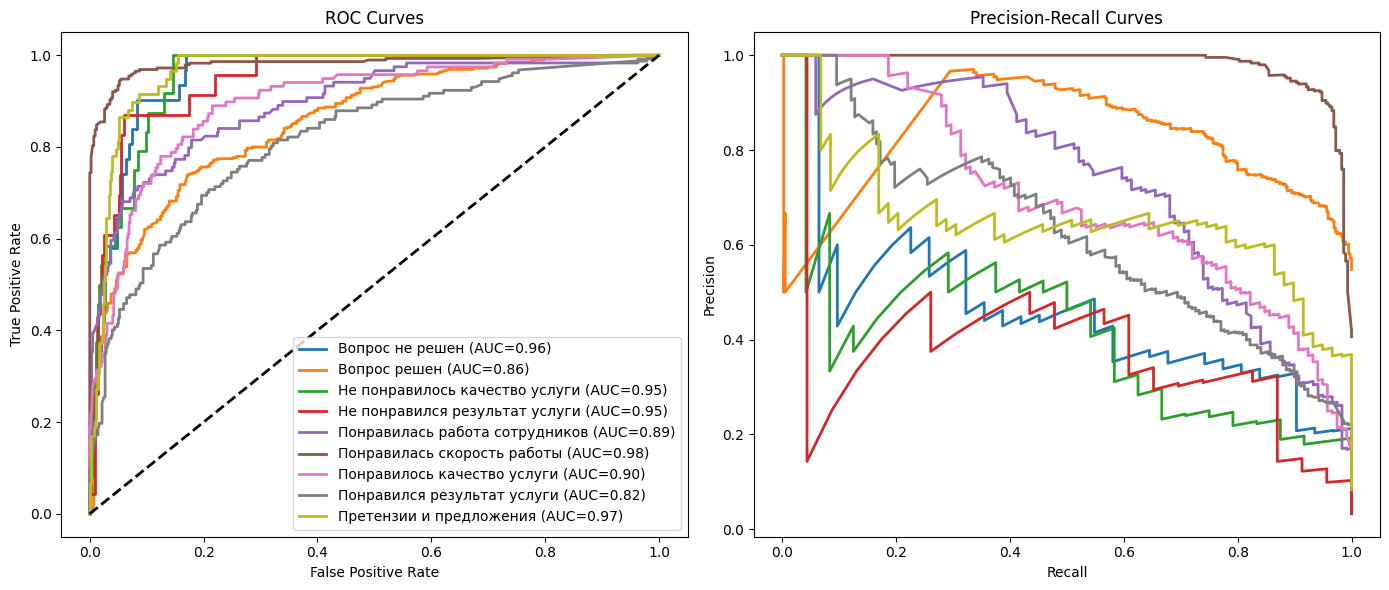

RandomForestClassifier
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос не решен                | roc-auc:1.00/0.95 | f1-macro:0.99/0.57 | f1-weighted:1.00/0.94 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос решен                   | roc-auc:0.99/0.84 | f1-macro:0.98/0.75 | f1-weighted:0.98/0.75 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравилось качество услуги | roc-auc:1.00/0.94 | f1-macro:0.99/0.53 | f1-weighted:1.00/0.95 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравился результат услуги | roc-auc:1.00/0.93 | f1-macro:0.99/0.49 | f1-weighted:1.00/0.95 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Понравилась работа сотрудников | roc-auc:1.00/0.89 | f1-macro:0.98/0.77 | f

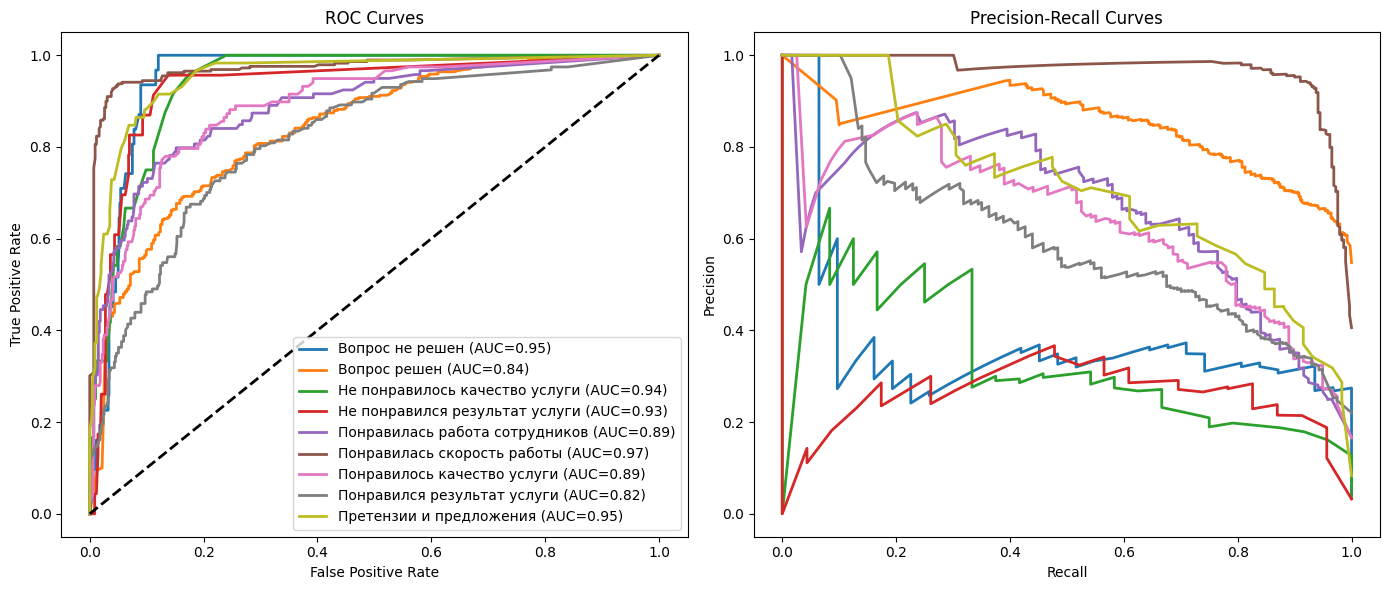

LinearSVC
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос не решен                | roc-auc:1.00/0.95 | f1-macro:0.99/0.68 | f1-weighted:1.00/0.95 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос решен                   | roc-auc:0.99/0.86 | f1-macro:0.96/0.76 | f1-weighted:0.97/0.76 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравилось качество услуги | roc-auc:1.00/0.95 | f1-macro:0.99/0.68 | f1-weighted:1.00/0.96 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравился результат услуги | roc-auc:1.00/0.94 | f1-macro:0.99/0.66 | f1-weighted:1.00/0.96 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Понравилась работа сотрудников | roc-auc:1.00/0.90 | f1-macro:0.98/0.81 | f1-weighted:0.

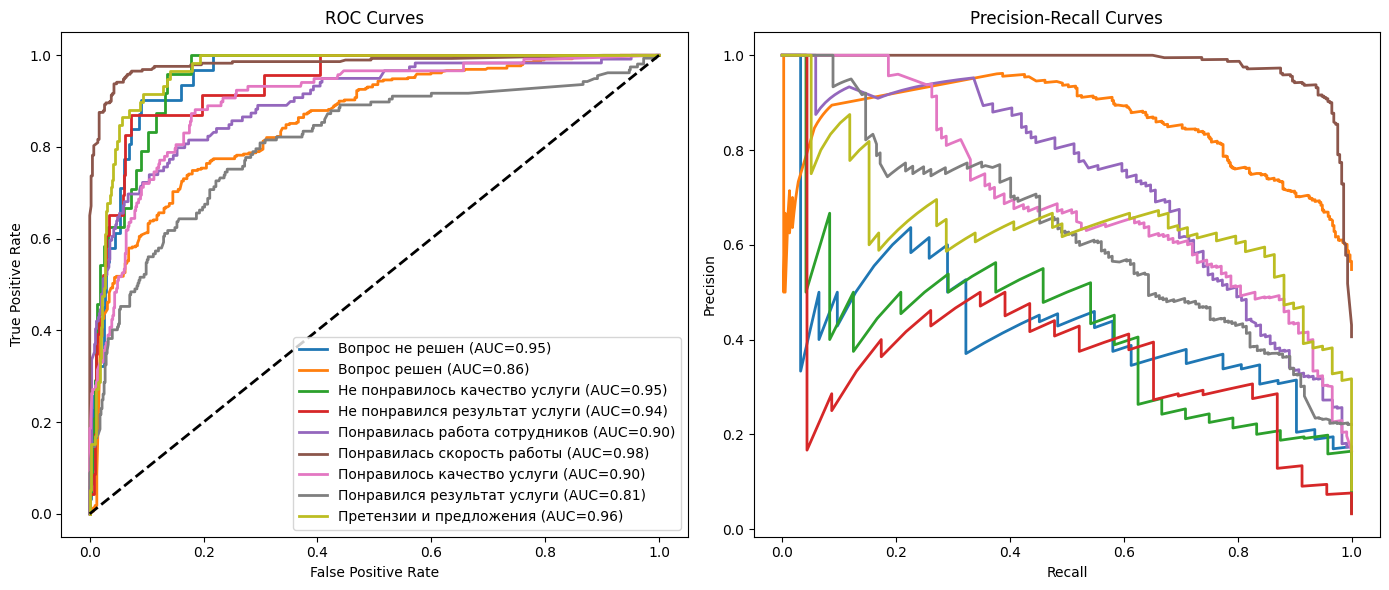

CatBoostClassifier
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос не решен                | roc-auc:1.00/0.95 | f1-macro:0.91/0.58 | f1-weighted:0.99/0.94 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Вопрос решен                   | roc-auc:0.95/0.84 | f1-macro:0.87/0.75 | f1-weighted:0.87/0.76 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравилось качество услуги | roc-auc:1.00/0.94 | f1-macro:0.94/0.58 | f1-weighted:0.99/0.95 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Не понравился результат услуги | roc-auc:1.00/0.92 | f1-macro:0.95/0.53 | f1-weighted:0.99/0.95 |
|--------------------------------|-------------------|--------------------|-----------------------|
| Понравилась работа сотрудников | roc-auc:0.99/0.90 | f1-macro:0.89/0.81 | f1-we

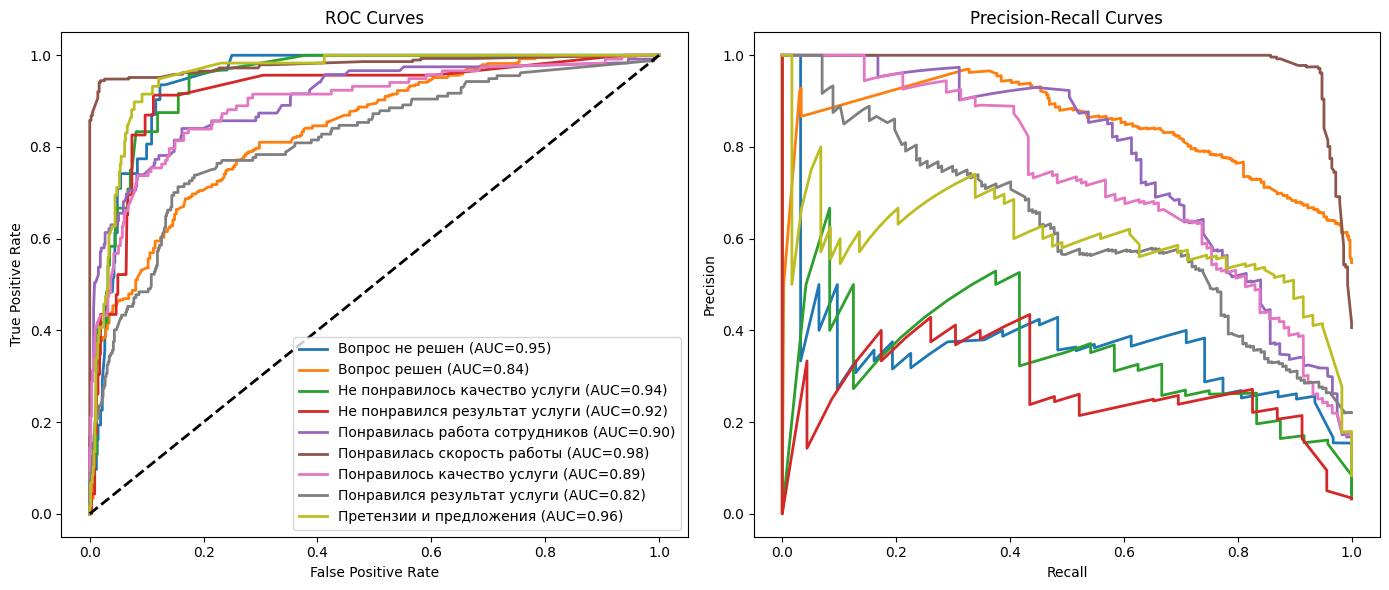

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'comment'),
                                                 ('num', StandardScaler(),
                                                  ['rating'])])),
                ('clf',
                 MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x00000248D18F9890>))])

In [55]:
TnS(model_logreg,"LogisticRegression")
TnS(model_rngfor,"RandomForestClassifier")
TnS(model_linsvc,"LinearSVC")
TnS(model_catbst,"CatBoostClassifier")

In [ ]:
new_comment="сотрудник быстро решил мой вопрос, качество услуги на высоте!"
new_rating=5
new_comment=lemmatize_text(new_comment)
predictions=predict_tags_with_proba(model,new_comment,new_rating)
for pred in predictions:
    print(f"{pred['tag']:<40} {pred['probability']:.3f} ({'✓' if pred['prediction'] else '✗'})")